# Reconstruction with real data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax import random
from jax.config import config
import mrcfile
import pickle
import time

from simplecryoem.emfiles import load_data
from simplecryoem.preprocess import preprocess
from simplecryoem.ab_initio import ab_initio_mcmc
from simplecryoem.forwardmodel import (
    project,
    rotate_and_interpolate,
    apply_shifts_and_ctf,
    Slice,
)
from simplecryoem.optimization import (
    Loss,
    GradV,
    conjugate_gradient,
    get_cg_vol_ops,
    sgd,
    get_sgd_vol_ops,
)
from simplecryoem.sampling import mcmc_sampling, CryoProposals
from simplecryoem.fsc import calc_fsc, points_orientations_tri, shell_points_used
from simplecryoem.utils import (
    plot_angles,
    mip_z,
    rescale_larger_grid,
    volume_fourier,
    err_orientations,
    create_3d_mask,
    l2sq,
    get_preconditioner,
)

In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6
config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read the data

In [6]:
# Out directory to save outputs
out_dir = "../../../simplecryoem_output"

In [8]:
data_dir = "../../../../Relion5_SPA_tutorial/"
star_file = "Refine3D/job029/run_data.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs=True, fourier=False)

load_data: number of partcles: 4452
load_data: data loaded, time:  8.25 sec.


### Preprocess the images

i.e. downsample, shuffle, compute grid, mask, estimate noise.

In [11]:
len(imgs0)

4452

In [13]:
nx0 = imgs0.shape[1]
nx_crop = 64
N = len(imgs0)
N_px_noise = 48
N_imgs_noise = 1000

processed_data = preprocess(
    imgs0,
    params0,
    nx_crop=nx_crop,
    N_px_noise=N_px_noise,
    N_imgs_noise=N_imgs_noise,
)

imgs_f = processed_data["imgs_f"]
pixel_size = processed_data["pixel_size"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]
idx = processed_data["idx"]
nx = processed_data["nx"]
x_grid = processed_data["x_grid"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
N = imgs_f.shape[0]

imgs0.shape = (4452, 256, 256)
pixel_size0.shape = (4452,)
angles0.shape = (4452, 3)
shifts0.shape = (4452, 2)
ctf_params0.shape = (4452, 9)
N0 = 4452
idx not provided
N = 4452
Taking FFT of the images:
Batch 1/10  0.46 sec.
Batch 2/10  0.46 sec.
Batch 3/10  0.46 sec.
Batch 4/10  0.46 sec.
Batch 5/10  0.46 sec.
Batch 6/10  0.46 sec.
Batch 7/10  0.46 sec.
Batch 8/10  0.46 sec.
Batch 9/10  0.46 sec.
Batch 10/10  0.46 sec.
FFT done. Time:  5.06 sec.
x_grid = [3.13796608e-03 2.56000000e+02]
new x_grid = [3.13796608e-03 6.40000000e+01]
Vectorised imgs_f.shape = (4452, 4096)
Mask radius = 0.09727694835058462
('Estimating the noise using the 48 x 48', 'corners of the first 1000 images.')
Estimating pixel-wise noise...done.
Averaging radially...done.
Noise estimation done. Time:  0.71 sec.


### Plot a few things

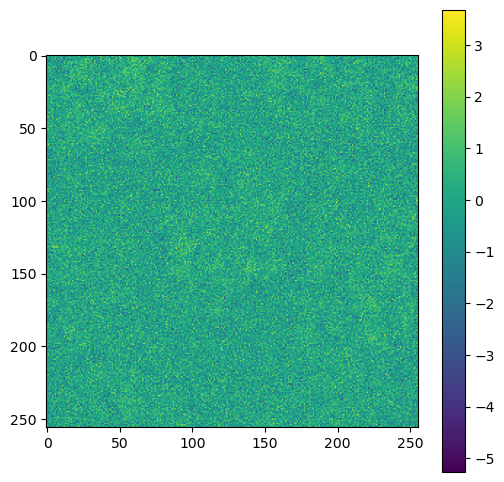

In [15]:
plt.imshow(imgs0[1])
plt.colorbar()

In [18]:
angles

array([[-1.82107898,  1.29890281,  1.44339153],
       [ 2.31204918,  1.25050122,  0.4275191 ],
       [ 2.33884559,  1.07053102,  1.3612584 ],
       ...,
       [ 2.01341183,  0.68037072,  0.28348582],
       [ 0.72052045,  1.26351467,  2.59664068],
       [ 0.20385034,  1.33361048,  1.34203682]])

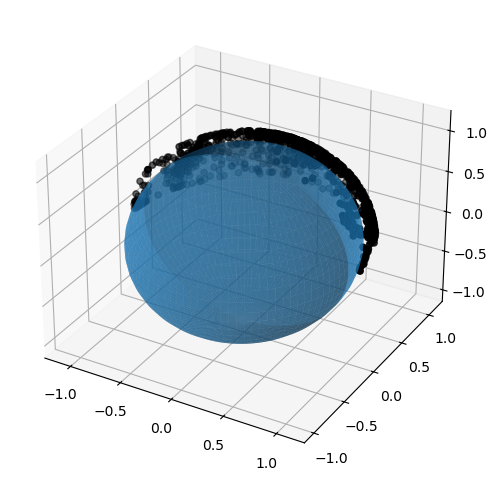

In [16]:
plot_angles(angles[np.random.permutation(imgs_f.shape[0] - 1)[:1000]])

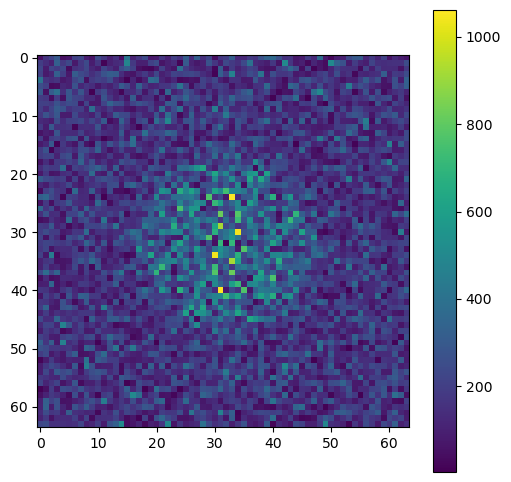

In [19]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[103].reshape([nx, nx]))))
plt.colorbar()

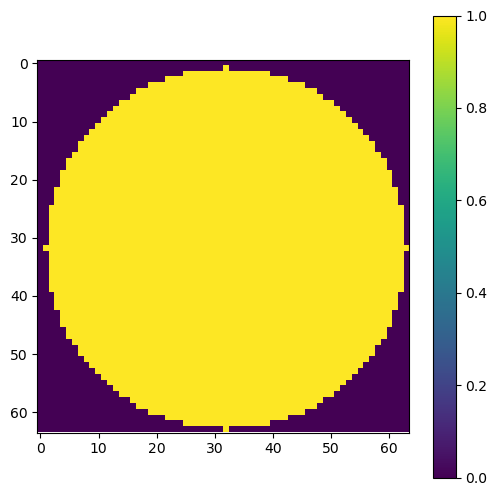

In [20]:
mip_z(jnp.fft.fftshift(mask))
plt.colorbar()

Text(0.5, 1.0, 'Estimated noise')

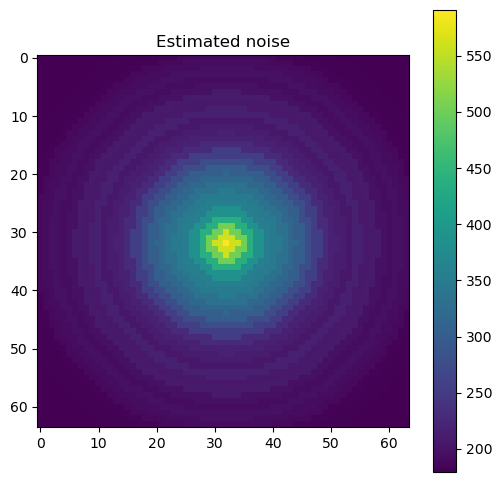

In [22]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx, nx])))
plt.colorbar()
plt.title("Estimated noise")

#### Delete the real images
Since we only work with the Fourier ones from now on.

In [23]:
del imgs0
# del(imgs)

### Ab initio

In [13]:
# Split in batches, note that imgs_batch stays on the CPU (i.e. np not jnp)
N_batch = 1
imgs_batch = np.array(np.array_split(imgs_f, N_batch))
angles_batch = jnp.array(np.array_split(angles, N_batch))
shifts_batch = jnp.array(np.array_split(shifts, N_batch))
ctf_params_batch = jnp.array(np.array_split(ctf_params, N_batch))

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))

# The number of iterations desn't matter,
# since it stops when the volume is nx x nx x nx.
N_iter = 100000000000

radius0 = 0.01
alpha = 1e-9

sgd_batch_size = 300
sgd_learning_rate = 10  # 1e5 #1e6
eps_init = 2e-8  # 1e-8

N_samples_vol = 201
N_samples_angles_global = 1001
N_samples_angles_local = 201
N_samples_shifts_global = 2  # 500
N_samples_shifts_local = 2  # 201

# HMC params
dt_list_hmc = jnp.array([0.1, 0.5, 1, 5, 10])
L_hmc = 5

sigma_perturb_list = jnp.array([1, 0.1, 0.01, 0.001])

pixel_size_nx = pixel_size[0]  # * nx0/nx

B = 0  # pixel_size[0] * 320/8
B_list = jnp.array([B / 2, B / 4, B / 8, B / 16])

minibatch_factor = 100
freq_marching_step_iters = 8

vol0 = None
angles0 = None  # angles_batch
shifts0 = shifts_batch
# sigma_noise = jnp.ones(sigma_noise.shape)


v_rec, angles_rec, shifts_recz = ab_initio_mcmc(
    key,
    project,
    rotate_and_interpolate,
    apply_shifts_and_ctf,
    imgs_batch,
    sigma_noise,
    ctf_params_batch,
    x_grid,
    vol0,
    angles0,
    shifts0,
    N_iter,
    sgd_learning_rate,
    sgd_batch_size,
    N_samples_vol,
    N_samples_angles_global,
    N_samples_angles_local,
    N_samples_shifts_global,
    N_samples_shifts_local,
    dt_list_hmc,
    sigma_perturb_list,
    L_hmc,
    radius0,
    None,
    alpha,
    eps_init,
    B,
    B_list,
    minibatch_factor,
    freq_marching_step_iters,
    "tri",
    True,
    True,
    True,
    True,
    out_dir,
)

In [18]:
out_dir

'../data/out_dev/'

In [28]:
# v_final = mrcfile.open(f"{out_dir}/rec_final.mrc").data
# v_rec,_,_ = volume_fourier(v_final, pixel_size[0])

In [30]:
v_rec_l, x_grid_l = rescale_larger_grid(v_rec, x_grid, nx0)
v_rec_rl = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l)))
with mrcfile.new(out_dir + "/rec_final_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(v_rec_rl.astype(np.float32))

In [ ]:
plot_angles(angles_rec[:2000])

In [ ]:
v_final = mrcfile.open(f"{out_dir}/rec_final.mrc").data
v_rec, _, _ = volume_fourier(v_final, pixel_size[0])
plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:, :, 0])))

In [ ]:
with open(f"{out_dir}/rec_iter_53_angles", "rb") as file:
    # Call load method to deserialze
    angles_rec = pickle.load(file)
    angles_rec = angles_rec[0]

In [ ]:
plot_angles(angles_rec)

In [ ]:
theta, cord_distance = err_orientations(angles, angles_rec)

nbins = 100
counts, bins = np.histogram(theta, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
v_rec_l, x_grid_l = rescale_larger_grid(v_rec, x_grid, 256)
v_rec_rl = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec_l)))
mip_z(v_rec_rl)
plt.colorbar()

In [ ]:
with mrcfile.new(f"{out_dir}/v_rec_alpha1e-9_nx0_ab_initio.mrc", overwrite=True) as mrc:
    mrc.set_data(v_rec_rl.astype(np.float32))

In [ ]:
out_dir

In [ ]:
with open(f"{out_dir}/idxrand", "rb") as file:
    # Call load method to deserialze
    idxrand = pickle.load(file)
    # z_rec = angles_rec[0]

In [ ]:
angles_rec.shape

In [ ]:
a1prev

In [ ]:
plt.rcParams["figure.figsize"] = 12, 6

a1prev = a1


with open(f"{out_dir}/rec_iter_45_angles", "rb") as file:
    # Call load method to deserialze
    # z_rec = pickle.load(file)
    angles_rec = pickle.load(file)[0]
    a1 = angles_rec[:, 0]


diff = a1 - a1prev

plt.plot(diff[:100])


# prevdiff = diff
# diff = z[idxrand]-z_rec
# plt.plot(diff[:100])
# plt.plot(prevdiff[:100])


# print(jnp.sum(diff-prevdiff != 0))

In [ ]:
jnp.sum(z[idxrand[:N]] - z_rec != 0)

In [ ]:
nbins = 100
counts, bins = np.histogram(z_rec, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
idxrand

## Sample individual variables

In [27]:
angles_rec = angles

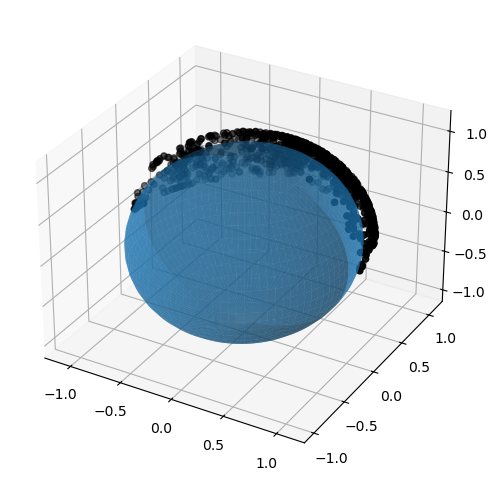

In [28]:
plot_angles(angles[:1000])

Read some angles and shifts from files if needed.

In [29]:
# with open("/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1_shifts_32_latest/rec_iter_704_angles", 'rb') as file:
#    # Call load method to deserialze
#    #z_rec = pickle.load(file)
#    angles = pickle.load(file)[0]
#
# with open("/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1_shifts_32_latest/rec_iter_704_shifts", 'rb') as file:
#    # Call load method to deserialze
#    #z_rec = pickle.load(file)
#    shifts = pickle.load(file)[0]

In [30]:
# with mrcfile.open("/gpfs/gibbs/pi/lederman/bt387/exp_data/output_simple_cryoem1_shifts_32_latest/rec_iter_704.mrc") as file:
#    vol0 = file.data
#
# vol0, _, _= volume_fourier(vol0, 1)
# vol0 = vol0.astype(jnp.complex128)
#
# print(f"vol.shape = {vol0.shape}")
# plt.imshow(np.abs(jnp.fft.fftshift(vol0[0]))); plt.colorbar()

Find a good value for B when sampling shifts

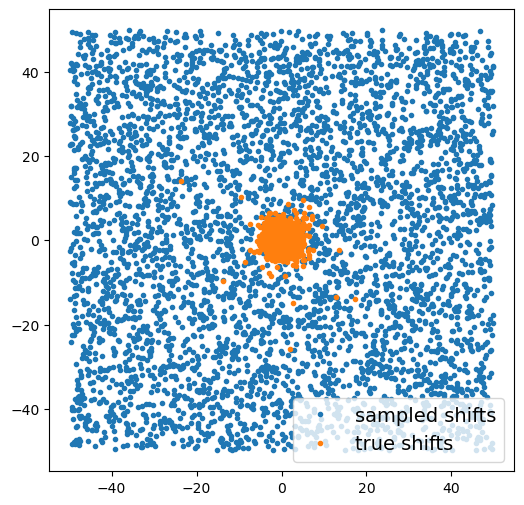

In [31]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
pixel_size_nx = pixel_size[0] * 320 / nx

B = pixel_size[0] * 320 / 8

sh = random.uniform(key, (N, 2)) * 2 * B - B

plt.plot(sh[:, 0], sh[:, 1], ".")
plt.plot(shifts[:, 0], shifts[:, 1], ".")
lgd = plt.legend(["sampled shifts", "true shifts"], fontsize=14)

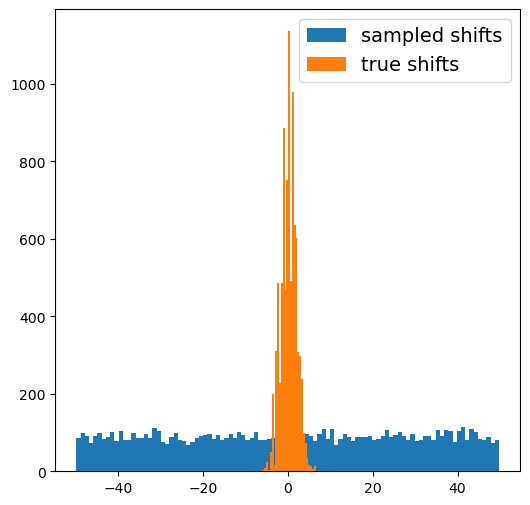

In [32]:
nbins = 100
counts, bins = np.histogram(shifts, bins=nbins)

nbins = 100
counts2, bins2 = np.histogram(sh, bins=nbins)

_ = plt.hist(bins2[:-1], bins2, weights=counts2)
_ = plt.hist(bins[:-1], bins, weights=counts)
lgd = plt.legend(["sampled shifts", "true shifts"], fontsize=14)

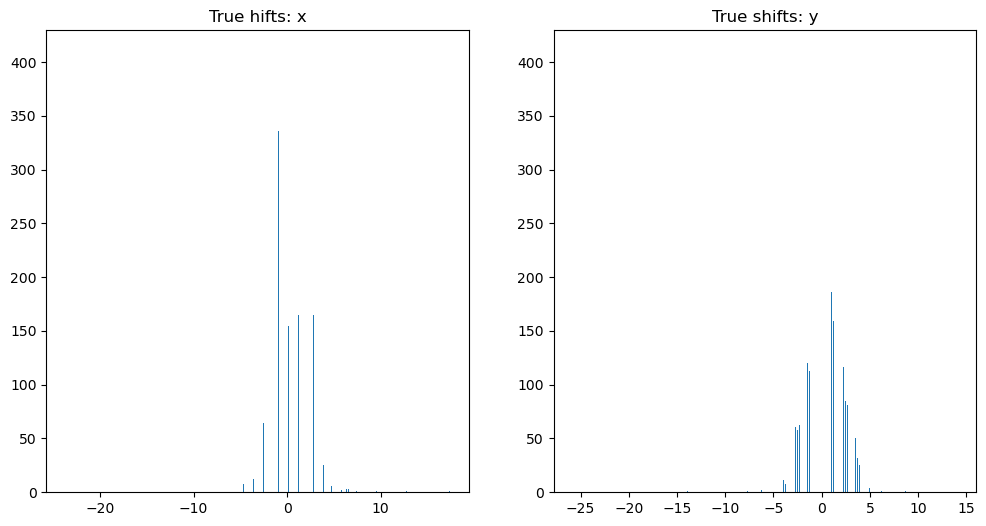

In [33]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)

nbins = 1000
counts, bins = np.histogram(shifts[:, 0], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)
plt.title("True hifts: x")


plt.subplot(1, 2, 2)
nbins = 1000
counts, bins = np.histogram(shifts[:, 1], bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)
plt.title("True shifts: y")

plt.rcParams["figure.figsize"] = 6, 6

#### Define the actual JAX objects used for sampling

In [34]:
alpha = 1e-9

radius = nx / 2 - 1
mask = create_3d_mask(np.array([1.0, 64.0]), (0, 0, 0), radius)
# mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1 / jnp.max(sigma_noise) ** 2 * jnp.ones([nx, nx, nx])
dt_list = jnp.array([0.1, 0.5, 1, 5, 10])
L = 5

B_list = jnp.array([B / 16])

slice_obj = Slice(x_grid)
loss_obj = Loss(slice_obj, alpha=alpha)
gradv_obj = GradV(loss_obj)
proposals = CryoProposals(
    sigma_noise, B, B_list, dt_list, L, M, slice_obj, loss_obj, gradv_obj
)

In [35]:
N_batch = 1
imgs_batch = np.array(np.array_split(imgs_f, N_batch))
angles_batch = np.array(np.array_split(angles, N_batch))
shifts_batch = np.array(np.array_split(shifts, N_batch))
ctf_params_batch = np.array(np.array_split(ctf_params, N_batch))

### 1. Volume

In [36]:
# If working with a subset:

# N = 1000

# imgs_f_full = imgs_f
# angles_full = angles
# shifts_full = shifts
# ctf_params_full = ctf_params

# imgs_f = imgs_f_full[:N]
# angles = angles_full[:N]
# shifts = shifts_full[:N]
# ctf_params = ctf_params_full[:N]

In [37]:
print(f"angles.shape = {angles.shape}")
print(f"imgs_f.shape = {imgs_f.shape}")

angles.shape = (4452, 3)
imgs_f.shape = (4452, 4096)


In [39]:
N_mc_samples = 10
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))

# v0 = (jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) )
v0 = jnp.zeros([nx, nx, nx]) * 1j
# v0 = v_rec
# v0 = v_hmc_mean

params_vol = {
    "angles": angles_batch,
    "shifts": shifts_batch,
    "ctf_params": ctf_params_batch,
    "imgs": imgs_batch,
}

t0 = time.time()
v_hmc_mean, r_hmc, v_hmc_samples = mcmc_sampling(
    key,
    proposals.proposal_vol_batch,
    v0,
    N_mc_samples,
    params_vol,
    save_samples=-1,
    iter_display=1,
)
print(time.time() - t0)

  MCMC sample 1, posterior val = -1877.5178838536967, a = 0.0
  MCMC sample 2, posterior val = -1826.9351387193715, a = 1.0
  MCMC sample 3, posterior val = -1820.7628417538656, a = 1.0
  MCMC sample 4, posterior val = -1820.6445855226555, a = 1.0
  MCMC sample 5, posterior val = -1820.5276634200554, a = 1.0
  MCMC sample 6, posterior val = -1813.4004780888754, a = 1.0
  MCMC sample 7, posterior val = -1813.4004780888754, a = 0.0
  MCMC sample 8, posterior val = -1813.4004780888754, a = 0.0
  MCMC sample 9, posterior val = -1813.3478470141342, a = 1.0
16.166093111038208


0.6666666666666666


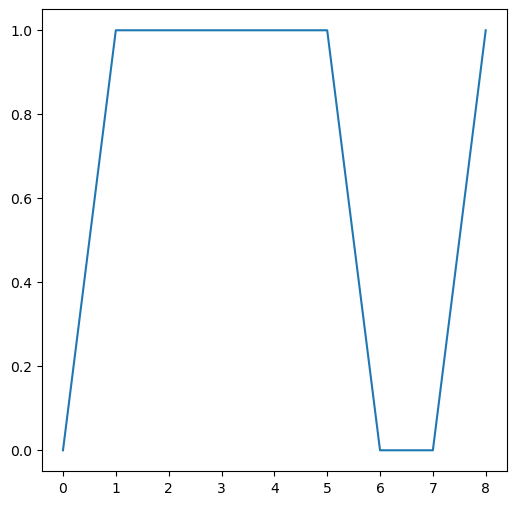

In [40]:
print(jnp.mean(r_hmc))
plt.plot(r_hmc)

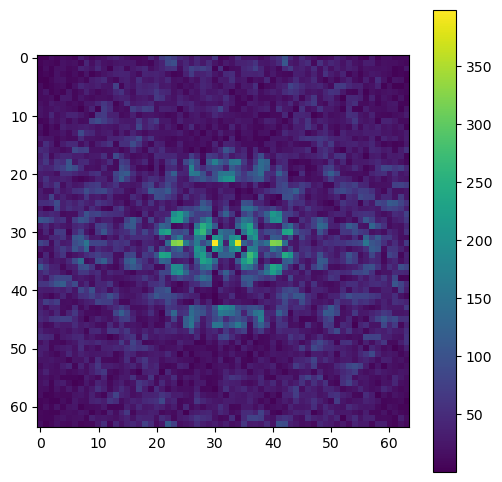

In [41]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_samples[0, :, :, 0])))
plt.colorbar()

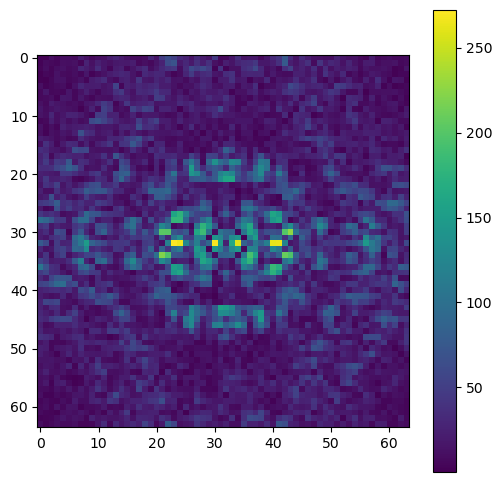

In [42]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_mean[:, :, 0])))
plt.colorbar()

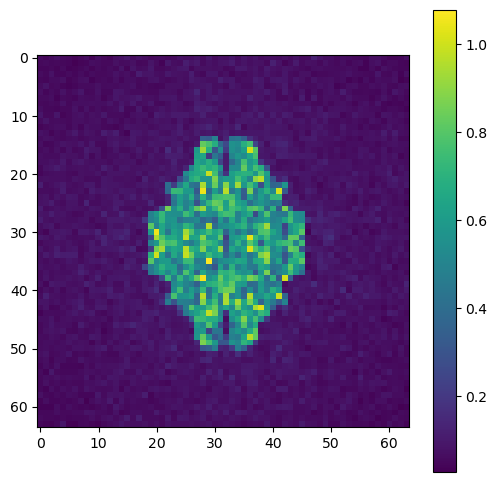

In [43]:
v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean)))

mip_z(v_hmc_r)
plt.colorbar()

In [44]:
with mrcfile.new(f"{out_dir}/v_hmc_mean.mrc", overwrite=True) as mrc:
    mrc.set_data(v_hmc_r.astype(np.float32))

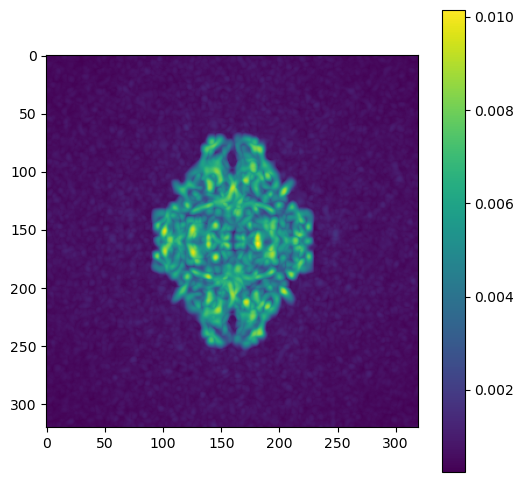

In [45]:
v_hmc_mean_l, x_grid_l = rescale_larger_grid(v_hmc_mean, x_grid, 320)
v_hmc_rl = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean_l)))
mip_z(v_hmc_rl)
plt.colorbar()

In [46]:
with mrcfile.new(f"{out_dir}/v_hmc_mean_nx0.mrc", overwrite=True) as mrc:
    mrc.set_data(v_hmc_rl.astype(np.float32))

In [48]:
#file = open(f"{out_dir}/angles_rec", "wb")
#pickle.dump(angles_rec, file)
#file.close()

#file3 = open(f"{out_dir}/shifts_rec", "wb")
#pickle.dump(shifts_rec, file3)
#file3.close()

In [ ]:
with open(f"{out_dir}/angles_rec", "rb") as file:
    # Call load method to deserialze
    angles_rec2 = pickle.load(file)

with open(f"{out_dir}/shifts_rec", "rb") as file:
    # Call load method to deserialze
    shifts_rec2 = pickle.load(file)

with open(f"{out_dir}/idxrand", "rb") as file:
    # Call load method to deserialze
    idxrand2 = pickle.load(file)

# Sanity check
assert jnp.sum(jnp.abs(angles_rec2 - angles_rec)) == 0
assert jnp.sum(jnp.abs(shifts_rec2 - shifts_rec)) == 0
assert jnp.sum(jnp.abs(idxrand2 - idxrand)) == 0

### 2. Global orientations + shifts (multiple-try Metropolis)

In [ ]:
# Volume obtained form sampling in the previous section

angles_true = angles
shifts_true = shifts
vol = v_hmc_mean

In [ ]:
NN = 40

N_mc_samples = 1000
key, subkey = random.split(key)

params = {
    "v": vol,
    "ctf_params": ctf_params[:NN],
    "imgs": imgs_f[:NN],
    "N_samples_shifts": 1000,
}

# as0 = jnp.array(np.random.randn(NN,5))
as0 = jnp.zeros([NN, 5])
# as0 = jnp.concatenate([angles_true[:NN], shifts_true[:NN]], axis=1)

t0 = time.time()
_, angles_shifts_r, angles_shifts_samples = mcmc(
    subkey,
    proposals.proposal_mtm_orientations_shifts,
    as0,
    N_mc_samples,
    params,
    NN,
    save_samples=-1,
    iter_display=50,
)
print(f"{time.time()-t0} seconds")

angles_rec = angles_shifts_samples[0, :, :3]
shifts_rec = angles_shifts_samples[0, :, 3:]

In [ ]:
print(shifts_rec[0])
print(shifts_true[0])

In [ ]:
print(shifts_rec[1])
print(shifts_true[1])

In [ ]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)
plt.plot(angles_shifts_r[:, 0])

plt.subplot(1, 2, 2)
plt.plot(angles_shifts_r[:, 1])

plt.rcParams["figure.figsize"] = 6, 6

In [ ]:
theta, cord_distance = err_orientations(angles[:NN], angles_rec)

nbins = 100
counts, bins = np.histogram((theta), bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
plt.plot(jnp.sort(cord_distance))

In [ ]:
theta, cord_distance = err_orientations(angles[:NN], as0[:, :3])

nbins = 100
counts, bins = np.histogram((theta), bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)

In [ ]:
plt.plot(jnp.sort(cord_distance))

### MCMC local shifts

In [ ]:
sh0 = shifts_batch

In [ ]:
N_mc_samples = 100
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
key, subkey = random.split(key)

vol0 = v_hmc_mean

proj = jnp.array(
    [
        slice_obj.rotate_and_interpolate_vmap(vol0, angles_batch[i])
        for i in jnp.arange(angles_batch.shape[0])
    ]
)

# sh0 = shifts_new

shifts_new = []
N_batch = shifts_batch.shape[1]


for i in jnp.arange(shifts_batch.shape[0]):
    print(f"Batch {i}")

    params_shifts = {
        "v": vol0,
        "proj": proj[i],
        "ctf_params": ctf_params_batch[i],
        "imgs": imgs_batch[i],
    }

    t0 = time.time()
    _, shifts_r, shifts_samples = mcmc(
        key,
        proposals.proposal_shifts_local,
        sh0[i],
        N_mc_samples,
        params_shifts,
        N_batch,
        save_samples=1,
        iter_display=10,
    )
    print(time.time() - t0)

    shifts_new.append(shifts_samples[N_mc_samples - 2])

shifts_new = jnp.array(shifts_new)

In [ ]:
plt.plot(shifts_r[:, 34])

In [ ]:
plt.plot(shifts_samples[:, 0, 1])

In [ ]:
shifts_samples[98, 0, 1]

In [ ]:
shifts[0]

### MCMC local perturbations for orientations

In [ ]:
# Load a volume
# vol_file = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/Refine3D/crossvalidation1/run_class001.mrc"
#
# with mrcfile.open(vol_file) as file:
#    v_r = file.data
#
# v, _, _ = volume_fourier(v_r, 1)
# mip_z(jnp.fft.fftshift(jnp.abs(v))); plt.colorbar()

In [ ]:
# a0 = jnp.array([generate_uniform_orientations_jax(subkey, angles_batch[0])])
a0 = angles_batch  # + np.random.randn(*angles_batch.shape) *0.1
v = vol0

In [ ]:
print(a0[0])
idx_batch = 0

key, subkey = random.split(key)
a1, _, _, _ = proposals.proposal_orientations_perturb(
    subkey,
    a0[idx_batch],
    jnp.inf * jnp.ones(shifts_batch.shape[1]),
    v,
    shifts_batch[idx_batch],
    ctf_params_batch[idx_batch],
    imgs_batch[idx_batch],
    jnp.array([0.01]),
)
print(a1[0])

In [ ]:
N_mc_samples = 400
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
key, subkey = random.split(key)

sigma_perturb_list = jnp.array([1, 0.1, 0.01, 0.001, 0.00001])

angles_new = []
N_batch = shifts_batch.shape[1]

for i in jnp.arange(shifts_batch.shape[0]):
    print(f"Batch {i}")

    params_angles = {
        "v": v,
        "shifts": shifts_new[i],
        "ctf_params": ctf_params_batch[i],
        "imgs": imgs_batch[i],
        "sigma_perturb": sigma_perturb_list,
    }

    t0 = time.time()
    _, angles_r, angles_samples = mcmc(
        key,
        proposals.proposal_orientations_perturb,
        a0[i],
        N_mc_samples,
        params_angles,
        N_batch,
        save_samples=1,
        iter_display=10,
    )
    print(time.time() - t0)

    angles_new.append(angles_samples[N_mc_samples - 2])

angles_new = jnp.array(angles_new)

In [ ]:
img_idx = 101
ang_idx = 2

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(
    angles_samples[:, img_idx, 0],
    angles_samples[:, img_idx, 1],
    angles_samples[:, img_idx, 2],
)
plt.show()

In [ ]:
angles_samples.shape

In [ ]:
nbins = 30
counts0, bins0 = np.histogram(angles_samples[:, img_idx, 0], bins=nbins)
_ = plt.hist(bins0[:-1], bins0, weights=counts0)

counts1, bins1 = np.histogram(angles_samples[:, img_idx, 1], bins=nbins)
_ = plt.hist(bins1[:-1], bins1, weights=counts1)

counts2, bins2 = np.histogram(angles_samples[:, img_idx, 2], bins=nbins)
_ = plt.hist(bins2[:-1], bins2, weights=counts2)

In [ ]:
plt.plot(
    jnp.mod(
        jnp.abs(angles_samples[:, img_idx, ang_idx] - angles[img_idx, ang_idx]),
        2 * jnp.pi,
    )
)

In [ ]:
theta0, cord_distance0 = err_orientations(angles_batch[0], a0[0])
theta_rec, cord_distance_rec = err_orientations(angles_batch[0], angles_new[0])

In [ ]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)
nbins = 100
counts, bins = np.histogram(theta0, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)
plt.title("Theta: a_0")

plt.subplot(1, 2, 2)
nbins = 100
counts, bins = np.histogram(theta_rec, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)
plt.title("Theta: a_rec")

plt.rcParams["figure.figsize"] = 6, 6

In [ ]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)
nbins = 100
counts, bins = np.histogram(cord_distance0, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)
plt.title("Cord distance: a_0")

plt.subplot(1, 2, 2)
nbins = 100
counts, bins = np.histogram(cord_distance_rec, bins=nbins)
_ = plt.hist(bins[:-1], bins, weights=counts)
plt.title("Cord distance: a_rec")

plt.rcParams["figure.figsize"] = 6, 6

In [ ]:
cd_sorted0 = jnp.sort(cord_distance0)
cd_sorted_rec = jnp.sort(cord_distance_rec)

plt.plot(cd_sorted0)
plt.plot(cd_sorted_rec)
plt.legend(["0", "rec"])

### CG - choosing $\alpha$

In [ ]:
centre = (0, 0, 0)
# radius = 0.045
radius = 0.093
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:, :, 0]

plt.imshow(jnp.fft.fftshift(mask2d))
plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [ ]:
slice_func, slice_func_array, slice_func_array_angles = get_slice_funcs(
    project, x_grid, mask, "tri"
)
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha=0)

The noise

In [ ]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

# sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx, nx])))
plt.colorbar()

In [ ]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [ ]:
N_iter = 50100
eps = 1e-4
# eps = 1e-5
# eps = 1e-3
# eps = 1e-6
v0 = jnp.zeros([nx, nx, nx]) * 1j
# alphas = [1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
# alphas = [1e-10, 1e-9, 1e-8]
alphas = [1e-8]
vcgs = []
fids = []
regs = []
losss = []
angles_cg = angles

In [ ]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print("alpha =", alpha)

    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(
        slice_func, alpha=alpha
    )
    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    AA, Ab = get_cg_vol_ops(
        grad_loss_volume_sum,
        angles_cg,
        shifts,
        ctf_params,
        imgs_f_m,
        v0.shape,
        sigma_noise,
    )
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose=True)

    fid = (
        2
        * fid_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)
        / (nx * nx)
    )
    reg = l2sq(vcg) / (nx * nx * nx)
    loss = loss_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise) / (
        nx * nx
    )

    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)

    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)

    print("  Time =", time.time() - t0)

vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

In [ ]:
plt.semilogx(alphas, fids)
plt.semilogx(alphas, regs)
plt.semilogx(alphas, losss)
plt.legend(["fid", "reg", "fid+reg"])

In [ ]:
plt.plot(fids)

In [ ]:
plt.semilogy(regs)

Pixel-wise loss for the best reconstruction:

In [ ]:
mask.shape

In [ ]:
def pixel_wise_fid_fun(v, slice_func_array, angles, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err) * err), axis=0) / (2 * sigma**2)
    # return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

In [ ]:
alphas[alpha_idx]

In [ ]:
sigma_noise1 = jnp.ones(sigma_noise.shape)

In [ ]:
pw_fid = pixel_wise_fid_fun(
    vcgs[0], slice_func_array, angles, shifts, ctf_params, imgs_f_m, sigma_noise1
)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx, nx])))
plt.colorbar()

Pixel-wise loss for the ZERO volume:

In [ ]:
pw_fid0 = pixel_wise_fid_fun(
    jnp.zeros(v0.shape),
    slice_func_array,
    angles_rec,
    shifts,
    ctf_params,
    imgs_f_m,
    sigma_noise1,
)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx, nx])))
plt.colorbar()

In [ ]:
alpha_idx = jnp.argmin(fids)
print(alpha_idx)

In [ ]:
# alpha_idx = 2

In [ ]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:, 0, :])))
plt.colorbar()

In [ ]:
img_idx = 100
s0 = slice_func(
    vcgs[alpha_idx], angles_cg[img_idx], shifts[img_idx], ctf_params[img_idx]
)
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx, nx)))
plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx, nx)))
plt.colorbar()

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx, nx)))
plt.colorbar()

In [ ]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title("Reconstruction MIP")

In [ ]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title("Reconstruction MIP")

In [ ]:
with mrcfile.new(
    "../../simplecryoem_output/Reconstruction_data/reconstruction_data_32_cg_alpha.mrc",
    overwrite=True,
) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### FSC, orientations, standard deviation for each voxel etc

In [ ]:
vcg1 = vcgs[0]
vcg2 = vcgs[6]

In [ ]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid)

In [ ]:
points_v_tri = points_orientations_tri(
    angles, x_grid[1].astype(jnp.int64), number_of_batches=1000
)
# points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

In [ ]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:, :, 0]))
plt.colorbar()

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines(
    [0.143, 0.5], xmin=min(res), xmax=max(res), colors=["gray"], linestyles=["dashed"]
)
plt.legend(["FSC", "fraction shell points used", "0.143, 0.5"])
# plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0, :, :] * mask[0, :, :])))))
plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:, 0, :] * mask[:, 0, :])))))
plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:, :, 0] * mask[:, :, 0])))))
plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA(vones)
omega = 1 / omega

In [ ]:
jnp.min(jnp.abs(omega))

In [ ]:
plt.title("Standard deviation")
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[0, :, :])))
plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:, 0, :])))
plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:, :, 0])))
plt.colorbar()

### SGD

### Preconditioner

In [ ]:
P = get_preconditioner(x_grid) * mask
# P = jnp.sqrt(P) /jnp.max(P) + 1e-6
# P = jnp.sqrt(P)
P = P**0.15
P = P / jnp.max(P) + 1e-6
plt.imshow(jnp.fft.fftshift(P[:, :, 0]))
plt.colorbar()
print(P[0, 0, 0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

In [ ]:
P = points_v_tri + 1
P = 1 / P * mask + 1e-12
P = P / jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:, :, 0]))
plt.colorbar()
print(P[0, 0, 0])
print(jnp.max(P))
print(jnp.min(P))

### $\alpha$ tuning

In [ ]:
mask2d = mask[:, :, 0]
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [ ]:
N_epoch = 501000
batch_size = 300
# learning_rate = 100000
learning_rate = 10000 * 100
# learning_rate = 10000 # for "large" alpha

P = None

# eps = 3e-5
# eps = 1e-3
# eps = 1e-9
eps = 1e-8
v0 = jnp.zeros([nx, nx, nx]) * 1j
# alphas = 1/100 * jnp.array([1e-9, 1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]) #, 1e0, 1e1, 1e2, 1e3]
# alphas = [1e-10, 1e-9, 1e-8, 1e-7]
alphas = [1e-9]

angles_gd = angles

In [ ]:
vgds = []
fids = []
regs = []
losss = []

# N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print("alpha =", alpha)

    slice_func, slice_func_array, slice_func_array_angles = get_slice_funcs(
        project, x_grid, mask, "tri"
    )
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(
        slice_func, alpha=alpha
    )

    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(
        grad_loss_volume_sum, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise
    )

    vgd = sgd(
        sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose=True
    )

    fid = (
        2
        * fid_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
        / (nx * nx)
    )
    reg = l2sq(vgd) / (nx * nx * nx)
    loss = loss_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise) / (
        nx * nx
    )

    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)

    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)

    print("  Time =", time.time() - t0)

vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

In [ ]:
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

N_alpha = len(fids)

In [ ]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(["fid", "reg", "fid+reg"])

In [ ]:
plt.plot(fids)

In [ ]:
plt.semilogy(regs)

In [ ]:
alphas[2]

In [ ]:
# alpha_idx= 3
# alpha_idx=5
# alpha_idx=0

In [ ]:
pw_fid = pixel_wise_fid_fun(
    vgds[alpha_idx],
    slice_func_array,
    angles_gd,
    shifts,
    ctf_params,
    imgs_f_m,
    sigma_noise,
)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx, nx])))
plt.colorbar()
print(jnp.max(pw_fid))

In [ ]:
pw_fid0 = pixel_wise_fid_fun(
    jnp.zeros(vgd.shape),
    slice_func_array,
    angles_gd,
    shifts,
    ctf_params,
    imgs_f_m,
    sigma_noise,
)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx, nx])))
plt.colorbar()
print(jnp.max(pw_fid))

In [ ]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx, :, 0, :])))
plt.colorbar()

In [ ]:
# plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

In [ ]:
# err = vgds[1] - v_rec
# plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

In [ ]:
vgds_s = vgds[:, :, 0, 0]
vgds_s.shape

plt.plot(jnp.abs(vgds_s[0]))
plt.plot(jnp.abs(vgds_s[1]) * 1.1)
plt.plot(jnp.abs(vgds_s[2]) * 2)
plt.plot(jnp.abs(vgds_s[3]) * 7)

In [ ]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))
mip_z(vr_sgd)
plt.colorbar()
plt.title("Reconstruction MIP")

In [ ]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title("Reconstruction MIP")

In [ ]:
with mrcfile.new(
    "../../simplecryoem_output/Reconstruction_data/reconstruction_data_32_sgd_alpha.mrc",
    overwrite=True,
) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [ ]:
idx = 100

In [ ]:
slicegd = slice_func(vgds[alpha_idx], angles_gd[idx], shifts[idx], ctf_params[idx])
# slicerec = slice_func(v_rec, angles_gd[idx], shifts[idx], ctf_params[idx])

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([nx, nx]))))
plt.colorbar()

In [ ]:
# plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([nx, nx]))))
plt.colorbar()

In [ ]:
def split(arr):
    N = arr.shape[0]
    N2 = jnp.floor(N / 2).astype(jnp.int32)

    arr_train = arr[:N2]
    arr_test = arr[N2:]

    return arr_train, arr_test


def split_and_triple(arr):
    N = arr.shape[0]
    N2 = jnp.floor(N / 2).astype(jnp.int32)

    arr_train = jnp.tile(arr[:N2], reps=(3, 1))
    arr_test = jnp.tile(arr[N2:], reps=(3, 1))

    return arr_train, arr_test


def split_and_triple_angles(a):
    N = a.shape[0]
    N2 = jnp.floor(N / 2).astype(jnp.int32)

    a_train1 = a[:N2]
    a_train2 = a_train1.copy()
    a_train3 = a_train1.copy()

    a_train2[:, 2] += 2 * jnp.pi / 3
    a_train3[:, 2] += 4 * jnp.pi / 3

    a_train = jnp.concatenate([a_train1, a_train2, a_train3], axis=0)

    a_test1 = a[N2:]
    a_test2 = a_test1.copy()
    a_test3 = a_test1.copy()

    a_test2[:, 2] += 2 * jnp.pi / 3
    a_test3[:, 2] += 4 * jnp.pi / 3

    a_test = jnp.concatenate([a_test1, a_test2, a_test3], axis=0)

    return a_train, a_test

In [ ]:
imgs_train, imgs_test = split_and_triple(imgs_f)
shifts_train, shifts_test = split_and_triple(shifts)
ctf_params_train, ctf_params_test = split_and_triple(ctf_params)
angles_train, angles_test = split_and_triple_angles(angles)
N = imgs_train.shape[0]

# plot_angles(angles[:1000])

In [ ]:
# imgs_train, imgs_test = split(imgs_f)
# shifts_train, shifts_test = split(shifts)
# ctf_params_train, ctf_params_test = split(ctf_params)
# angles_train, angles_test = split(angles)
# N = imgs_train.shape[0]
# plot_angles(angles_train)